## consider dim

In [21]:
# ==================
# library
# ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
%matplotlib inline
pd.set_option('display.max_columns', 300)



In [22]:
data = '../datasets/'
out_dir = '../output/'
TRAIN_PATH = data+"train.csv"
TEST_PATH = data+ 'test.csv'
SUB_PATH = data + 'atmacup10__sample_submission.csv'
SAVE_TEST_SUB_PATH = out_dir + "sub.csv"

In [23]:
# ===============
# Settings
# ===============

SEED = 0
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 200,
}



In [24]:
# =====================
# Function
# =====================
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, feature_name, fold_id,lgb_params, fit_params, loss_func, calc_importances=True):
    
    train_df = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        feature_name=feature_name)
    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            feature_name=feature_name)
   
    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train_df,
            valid_sets=[train_df,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train_df,
            **fit_params
        )
    
    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None
    
    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    if calc_importances:
        importances = pd.DataFrame()
        importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration

def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))
def get_dim(df):
    df['dim'] = ''
#     df[df['sub_title'].isnull()] = '0'
    df['dim'] = df['sub_title'].str.count('×')
#     for i in range(len(df)):
#         df['dim'][i] = df['sub_title'][i].count('×')+1
#     df['dim'] = df['dim'].astype(int)
    return df
def get_collection(df, collections):
    obj_collection_df = pd.read_csv('../datasets/object_collection.csv')
    df ['has_collection'] = df['object_id'].isin(obj_collection_df['object_id'])*1
    for collect in collections:
        print(collect)
        df['has_'+collect] = ''
        df['has_'+collect] = df['object_id'].isin(obj_collection_df['object_id'][obj_collection_df['name'] == collect])*1
    return df
def has_description(df):
    df['has_description'] = ''
    df['has_description'] = ~df['description'].isnull()*1
    return df
def concat_material(df):
    material = pd.read_csv('../datasets/material.csv')
    cross_material = pd.crosstab(material['object_id'], material['name'])
    df = df.merge(cross_material, on = 'object_id',how='left' )
    return df, cross_material.columns
def buy_on_loan(df):
    df['buy_loan'] = ''
    df['buy_loan'] = df['acquisition_method'] == 'loan'
    print(df['buy_loan'].sum())
    return df
def concat_teck(df):
    teq = pd.read_csv('../datasets/technique.csv')
    cross_teq = pd.crosstab(teq['object_id'], teq['name'])
    df = df.merge(cross_teq, on = 'object_id',how='left' )
    return df, cross_teq.columns
def check_grams(df):
    sub_title_df = df['sub_title']

    split = sub_title_df.str.split(' × ',expand=True)
    size_df = pd.DataFrame(columns = [0,1,2,3,4])
    for i in range(len(split.columns)):
        size_df[i] = split[i][~split[i].isnull()].str.split(' ',expand=True)[1]

    size_df = size_df.fillna('1')

    size_mm_df = size_df.replace('cm','mm10',regex=True)

    df['has_g'] = 0
    for i in range(len(size_mm_df.T)):
         df['has_g'] += size_mm_df[i].str.contains('g')*1
    return df

In [25]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
len_train = len(train_df)
y = np.log1p(train_df["likes"])

In [26]:
collections = ['paintings','prints']
train_df = get_collection(train_df,collections)
test_df = get_collection(test_df,collections)

paintings
prints
paintings
prints


In [27]:
train_df = get_dim(train_df)
test_df = get_dim(test_df)

In [28]:
train_df = has_description(train_df)
test_df = has_description(test_df)

In [29]:
train_df,_= concat_material(train_df)
test_df, material_col = concat_material(test_df)

In [30]:
train_df,_= concat_teck(train_df)
test_df, teq_col = concat_teck(test_df)

In [31]:
train_df = buy_on_loan(train_df)
test_df  = buy_on_loan(test_df)

404
374


In [32]:
train_df = check_grams(train_df)
test_df = check_grams(test_df)

sub_title_df = train_df['sub_title']

split = sub_title_df.str.split(' × ',expand=True)

for i in range(len(split.columns)):
    size_df[i] = split[i][~split[i].isnull()].str.split(' ',expand=True)[1]

size_df = size_df.fillna('1')

size_mm_df = size_df.replace('cm','mm10',regex=True)

train_df['has_g'] = 0
for i in range(len(size_mm_df.T)):
     train_df['has_g'] += size_mm_df[i].str.contains('g')*1

In [33]:
teq_col

Index(['Valenciennes lace', 'albumen print', 'ambrotype', 'brush',
       'carbon print', 'collotype', 'colour woodcut', 'counterproof',
       'cutting', 'cyanotype', 'drypoint', 'engraving', 'etching',
       'ferrotyping', 'gelatin silver print', 'gelatin silver slide on glass',
       'gilding', 'inkjet print', 'lacquering', 'letterpress printing',
       'litho etching', 'oil transfer print', 'painting', 'pen', 'perforating',
       'photolithography', 'printed matter', 'printing', 'salted paper print',
       'slide', 'steel engraving', 'writing (processes)'],
      dtype='object', name='name')

In [34]:
train_df.info

<bound method DataFrame.info of                   object_id         art_series_id  \
0      0011d6be41612ec9eae3  93c092ba70beab248f31   
1      0012765f7a97ccc3e9e9  95c14fb11c54281ad7e0   
2      0017be8caa87206532cb  4c406890d208fe01f8fb   
3      00181d86ff1a7b95864e  fa0891535500a4973db2   
4      001c52ae28ec106d9cd5  8065ed5063c5887e677d   
...                     ...                   ...   
12021  ffedf8af4fd5b3873164  2e4695e7f3260d52b3e6   
12022  ffee34705ea44e1a0f79  7aa656a9ef243d93d009   
12023  ffefbe1faf771aa4f790  e79c2e74ed17533a7e56   
12024  fff08e76cbb969eaddc7  510358b74c1104edbbbd   
12025  fff1d87d79953ddab2c6  b5b9203624d1f0db99a9   

                                                   title  \
0                                  The Avenue of Birches   
1                                        Struik in bloei   
2                                  Portret van een vrouw   
3                                       A St Bernard Dog   
4                            Wo

In [35]:
train_df

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,has_collection,has_paintings,has_prints,dim,has_description,China paper,Japanese paper (handmade paper),RC paper,acrylic paint,alloy,amalgam,asbestos,asbestos-cement,ball-point pens,baryta paper,brass (alloy),bronze (metal),canvas,cardboard,casein paint,celluloid (cellulosic),chalk,copper (metal),cotton (textile),deck paint,enamel paint,gilding (material),glass,gold (metal),gold leaf,gouache (paint),hardboard,horn (animal material),human hair,ink,iron (metal),ivory,jade (rock),lacquer (coating),lead (metal),leather,linden,linen (material),looking glasses,mahogany (wood),metal,mother of pearl,oak (wood),oil (organic material),oil paint (paint),paint (coating),panel,paper,papier mâché,parchment (animal material),particle board,pear (wood),pencil,photographic paper,plush,plywood,poplar (wood),porcelain,prepared paper,printing ink,rope,silk,silver (metal),silver leaf,slate (rock),softwood,tempera,textile materials,tin (metal),tin alloy,tracing paper,transparant paper,velvet (fabric weave),watercolor (paint),wax,wood (plant material),wood board,Valenciennes lace,albumen print,ambrotype,brush,carbon print,collotype,colour woodcut,counterproof,cutting,cyanotype,drypoint,engraving,etching,ferrotyping,gelatin silver print,gelatin silver slide on glass,gilding,inkjet print,lacquering,letterpress printing,litho etching,oil transfer print,painting,pen,perforating,photolithography,printed matter,printing,salted paper print,slide,steel engraving,writing (processes),buy_loan,has_g
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,1,1,0,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,0,0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,0.0
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,0,0,0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [36]:
cols = ['principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late','has_prints',
        'has_paintings',
        'has_collection',
        'dim',
        'has_description',
        'buy_loan',
        'has_g'
       ]
cols.extend(material_col)
cols.extend(teq_col)
cat_cols = ['principal_maker', 'principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line','dim','has_g']
cat_cols.extend(material_col)
cat_cols.extend(teq_col)

In [37]:
for c in cat_cols:
    train_df.loc[~train_df[c].isin(test_df[c].unique()),c] = np.nan
    test_df.loc[~test_df[c].isin(train_df[c].unique()),c] = np.nan
train_df = pd.concat([train_df[cols],test_df[cols]]).reset_index(drop=True)

In [38]:
for c in cat_cols:
    train_df[c] = train_df[c].astype(str)
    le = LabelEncoder()
    train_df[c] = le.fit_transform(train_df[c])

In [39]:
test_df = train_df.iloc[len_train:].reset_index(drop=True)
train_df = train_df.iloc[:len_train].reset_index(drop=True)

In [40]:
kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)
y_oof = np.empty([len(train_df),])
y_test = []
features = list(train_df.columns)
drop_cols = []
features = [i for i in features if i not in drop_cols]
feature_importances = pd.DataFrame()
categorical_features = ["principal_maker","principal_or_first_maker"]
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df,y)):
    print('Fold {}'.format(fold + 1))
    print(valid_idx)
    x_train, y_train = train_df.iloc[train_idx][features], y.iloc[train_idx]
    x_val, y_val =train_df.iloc[valid_idx][features], y.iloc[valid_idx]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter = train_lgbm(
                x_train, y_train, x_val, y_val,test_df[features],
                categorical_features=categorical_features,
                feature_name=features,
                fold_id=fold,
                lgb_params=LGBM_PARAMS,
                fit_params=LGBM_FIT_PARAMS,
                loss_func=calc_loss,
                calc_importances=True
            )

    y_oof[valid_idx] = y_pred_valid
    score = calc_loss(y[valid_idx], y_pred_valid)
    y_test.append(y_pred_test)
    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

score = calc_loss(y, y_oof)
print(score)

Fold 1
[    9    14    16 ... 12011 12021 12025]
Training until validation scores don't improve for 200 rounds


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 0.997955	valid_1's rmse: 1.09271
[400]	training's rmse: 0.951704	valid_1's rmse: 1.09271
Early stopping, best iteration is:
[253]	training's rmse: 0.98305	valid_1's rmse: 1.08994
Fold 2
[    5    15    20 ... 12016 12017 12020]


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.00645	valid_1's rmse: 1.07052
[400]	training's rmse: 0.960597	valid_1's rmse: 1.06678
[600]	training's rmse: 0.929266	valid_1's rmse: 1.06481
Early stopping, best iteration is:
[501]	training's rmse: 0.943585	valid_1's rmse: 1.06443
Fold 3
[    1     4     6 ... 12012 12013 12024]
Training until validation scores don't improve for 200 rounds


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 0.990926	valid_1's rmse: 1.12021
[400]	training's rmse: 0.943903	valid_1's rmse: 1.11537
Early stopping, best iteration is:
[380]	training's rmse: 0.947699	valid_1's rmse: 1.11442
Fold 4
[    2     3    10 ... 12018 12019 12022]


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.00635	valid_1's rmse: 1.077
[400]	training's rmse: 0.961405	valid_1's rmse: 1.07032
[600]	training's rmse: 0.93066	valid_1's rmse: 1.06879
[800]	training's rmse: 0.906845	valid_1's rmse: 1.07027
Early stopping, best iteration is:
[622]	training's rmse: 0.927867	valid_1's rmse: 1.06794
Fold 5
[    0    13    21 ... 12006 12008 12023]
Training until validation scores don't improve for 200 rounds


/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/wsato/work/pyvenv/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.00288	valid_1's rmse: 1.07141
[400]	training's rmse: 0.956137	valid_1's rmse: 1.06959
[600]	training's rmse: 0.92521	valid_1's rmse: 1.07002
Early stopping, best iteration is:
[471]	training's rmse: 0.944093	valid_1's rmse: 1.06864
1.0812403885441457


In [41]:
feature_importances

,feature,gain,split,fold
0,principal_maker,8784.792238,673,0
1,principal_or_first_maker,10208.772691,518,0
2,copyright_holder,165.540955,36,0
3,acquisition_method,4006.172797,519,0
4,acquisition_credit_line,3824.982693,788,0
...,...,...,...,...
119,printing,8.897170,2,4
120,salted paper print,49.091335,12,4
121,slide,90.010169,28,4
122,steel engraving,38.786575,20,4


In [42]:
a = np.linspace(0,max(y),len(y))

In [43]:
len(a)

12026

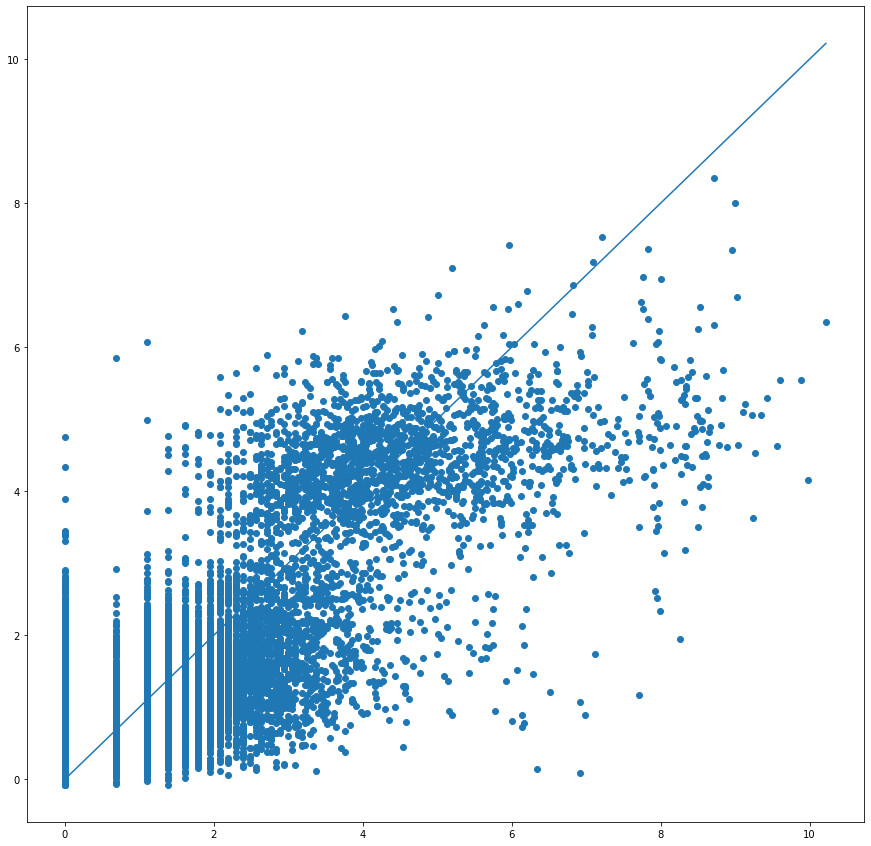

In [46]:
plt.figure(figsize=(15,15))
plt.scatter(y,y_oof)
plt.plot(a,a)


In [45]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)